In [1]:
import math
import os
import warnings

import dask.distributed
import matplotlib
import matplotlib.pyplot as plt
import ncar_jobqueue
import numpy as np
import xarray as xr

import utils
from utils.utils import propagate_coord_bounds, to_netcdf_prep, round_sig, gen_hash

%matplotlib inline
%load_ext autoreload
%autoreload 2


## specify experiments to process and analysis parameters


In [2]:
casenames = [
    "g.e22.G1850ECO_JRA_HR.TL319_t13.003",
    "g.e22.G1850ECO_JRA_HR.TL319_t13.004",
]

varname = "O2"
sum_dims = ["nlat", "nlon"]
thres_vals = np.array([-0.1, 0.0, 5.0, 10.0, 20.0, 40.0])
region_mask_vals = np.array([2, 3, 6])

cache_dir = os.path.join(
    os.sep, "glade", "work", "klindsay", "cache", "HiRes-CESM-analysis"
)
os.makedirs(cache_dir, exist_ok=True)

## analysis function


In [3]:
def var_lt_thres_weight_sum(
    ds,
    varname,
    weight,
    thres_vals,
    isel_dict,
    sum_dims=None,
    cache_dir=None,
    cache_clobber=False,
    **open_dataset_kwargs,
):
    """
    compute sum of weight where varname is less than values in thres_vals

    ds: Dataset containing varname and region mask variables
    varname: name of DataArray that function is being applied to
    weight: DataArray to be summed where varname is less than threshold
        example usecases are grid cell area or volume
    thres_vals: numpy array of threshold values
    isel_dict: selection dictionary applied before computing
    sum_dims: dimension(s) over which to apply sum, default is all dimensions
    """
    if cache_dir is None:
        cache_valid = False
    else:
        hash_val = gen_hash([weight.values, thres_vals])

        cache_path = gen_cache_path(
            cache_dir,
            "var_lt_thres_weight_sum",
            ds,
            varname,
            isel_dict,
            sum_dims,
        )
        print(f"cache_path={cache_path}")

        if os.path.exists(cache_path) and not cache_clobber:
            ds_out = xr.open_dataset(cache_path, **open_dataset_kwargs)
            cache_valid = ds_out.attrs["hash_val"] == hash_val
            print(f"cache_valid={cache_valid}")
        else:
            print("cache_path doesn't exist or cache_clobber=True")
            cache_valid = False

    if not cache_valid:
        ds_out = var_lt_thres_weight_sum_core(
            ds, varname, weight, thres_vals, isel_dict, sum_dims
        ).compute()
        if cache_dir is not None:
            ds_out = to_netcdf_prep(ds_out, ds_in=ds)
            ds_out.attrs["hash_val"] = hash_val
            ds_out.to_netcdf(cache_path)
    else:
        ds_out.load()

    return ds_out


def var_lt_thres_weight_sum_core(
    ds, varname, weight, thres_vals, isel_dict, sum_dims
):
    # generate da of weight where ds[varname] < threshold values
    da = ds[varname].isel(isel_dict).expand_dims(dim={"thres": thres_vals})
    weight_da_lt_thres = xr.where((da < da.thres), weight, 0.0)

    ds_out = ds[["time"]].isel(isel_dict)
    ds_out = propagate_coord_bounds(ds_out, ds_in=ds)

    varname_out = f"{varname}_lt_thres_weight_sum"
    ds_out[varname_out] = weight_da_lt_thres.sum(sum_dims)

    return ds_out


def gen_cache_path(cache_dir, fcn_name, ds, varname, isel_dict, sum_dims):
    # construct full path of cache file
    cache_filename_terms = [fcn_name, ds.attrs["title"], varname]
    for isel_key, isel_val in isel_dict.items():
        cache_filename_terms.append(isel_key)
        if isinstance(isel_val, slice):
            cache_filename_terms.append(str(isel_val.start))
            cache_filename_terms.append(str(isel_val.stop))
            if isel_val.step is not None:
                cache_filename_terms.append(str(isel_val.step))
        else:
            cache_filename_terms.append(str(isel_val))
    if sum_dims is not None:
        cache_filename_terms.append("sum_dims")
        if type(sum_dims) == str:
            cache_filename_terms.append(sum_dims)
        else:
            for dim in sum_dims:
                cache_filename_terms.append(dim)
    return os.path.join(cache_dir, "_".join(cache_filename_terms) + ".nc")

## acquire computational resources


In [4]:
cluster = ncar_jobqueue.NCARCluster(
    cores=1, memory="24 GB", processes=1, walltime="6:00:00"
)
# cluster.scale(n=32)  # n = number of workers
cluster.adapt(maximum=32, interval="10 s")
print(f"dashboard_link={cluster.dashboard_link}")
client = dask.distributed.Client(cluster)
# client.get_versions(check=True)

dashboard_link=https://jupyterhub.ucar.edu/dav/user/klindsay/proxy/8787/status


## perform analysis on specified experiments


In [5]:
ds_dict = {}

for casename in casenames:
    campaign_root = os.path.join(
        os.sep,
        "glade",
        "campaign",
        "cesm",
        "development",
        "bgcwg",
        "projects",
        "hi-res_JRA",
        "cases",
    )
    output_roots = [os.path.join(campaign_root, casename, "output")]

    caseroot = os.path.join(
        os.sep, "glade", "work", "mlevy", "hi-res_BGC_JRA", "cases", casename
    )
    output_roots += utils.gen_output_roots_from_caseroot(caseroot)

    case = utils.CaseClass(casename, output_roots)

    chunks = {"time": 1, "z_t": 1}

    ds = case.gen_dataset(
        varname,
        stream="pop.h",
        vars_to_keep=["dz", "REGION_MASK", "KMT"],
        chunks=chunks,
    )

    # weight is area [cm^2] for abs(latitude) < 30
    weight = xr.where(
        (abs(ds["TLAT"]) < 30.0) & (ds["KMT"] > 0), ds["TAREA"], 0.0
    )

    # add region dimension to weight
    weight = weight.expand_dims(dim={"region_mask": region_mask_vals})
    weight = xr.where(ds["REGION_MASK"] == weight.region_mask, weight, 0.0)

    # generate results in segments, by selecting along time dim with segments of length time_step
    time_len = len(ds["time"])
    time_step = 12
    ds_list = []
    for t_ind in range(0, time_len, time_step):
        isel_dict = {"time": slice(t_ind, min(time_len, t_ind + time_step))}
        print(isel_dict)
        ds_out = var_lt_thres_weight_sum(
            ds,
            varname=varname,
            weight=weight,
            thres_vals=thres_vals,
            isel_dict=isel_dict,
            sum_dims=sum_dims,
            cache_dir=cache_dir,
            chunks=chunks,
        )
        ds_out["dz"] = ds["dz"]
        print("var_lt_thres_weight_sum returned")
        ds_list.append(ds_out)

    print("concatenating result segments over time")
    varname_out = f"{varname}_lt_thres_weight_sum"
    ds_full = xr.concat(
        ds_list,
        dim="time",
        data_vars=[varname_out],
        coords="minimal",
        compat="override",
    )
    print(ds_full)
    ds_dict[casename] = ds_full

Datasets contain a total of 48 time samples
Last average written at 0005-01-01 00:00:00
{'time': slice(0, 12, None)}
cache_path=/glade/work/klindsay/cache/HiRes-CESM-analysis/var_lt_thres_weight_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_0_12_sum_dims_nlat_nlon.nc
cache_valid=True
var_lt_thres_weight_sum returned
{'time': slice(12, 24, None)}
cache_path=/glade/work/klindsay/cache/HiRes-CESM-analysis/var_lt_thres_weight_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_12_24_sum_dims_nlat_nlon.nc
cache_valid=True
var_lt_thres_weight_sum returned
{'time': slice(24, 36, None)}
cache_path=/glade/work/klindsay/cache/HiRes-CESM-analysis/var_lt_thres_weight_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_24_36_sum_dims_nlat_nlon.nc
cache_valid=True
var_lt_thres_weight_sum returned
{'time': slice(36, 48, None)}
cache_path=/glade/work/klindsay/cache/HiRes-CESM-analysis/var_lt_thres_weight_sum_g.e22.G1850ECO_JRA_HR.TL319_t13.003_O2_time_36_48_sum_dims_nlat_nlon.nc
cache_valid=True
var_lt_thre

## release computational resources


In [6]:
client.close()
cluster.close()

## function that creates figures from analysis output


In [7]:
def omz_plot(varname, region_mask_val):
    varname_out = f"{varname}_lt_thres_weight_sum"
    depth_subset = slice(0.0, 2500.0e2)

    for thres_val in [0.0, 5.0, 10.0, 40.0]:
        sel_dict = {"region_mask": region_mask_val, "thres": thres_val}
        sel_dict["z_t"] = depth_subset
        print(sel_dict)

        # generate contour levels for time-depth contour plots
        # compute max over cases
        max_val = max(
            [
                ds_dict[casename].sel(sel_dict)[varname_out].max()
                for casename in casenames
            ]
        )
        level_delta = round_sig(max_val.values / 10, 2)
        nlevels = math.ceil(max_val / level_delta)
        levels = np.linspace(0.0, level_delta * nlevels, nlevels + 1)

        for casename in casenames:

            ds = ds_dict[casename].sel(sel_dict)
            da = ds[varname_out]

            # time-depth contour plot of area
            # ignore certain warnings
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    action="ignore",
                    category=matplotlib.MatplotlibDeprecationWarning,
                )
                da.transpose("z_t", ...).plot.contourf(
                    cmap="Blues", levels=levels
                )
            plt.gca().invert_yaxis()
            title = f"Area, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

            # timeseries plot of volume
            omz_vol = (da * ds["dz"]).sum("z_t")
            omz_vol.plot.line("-o")
            title = f"Volume, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

            # timeseries plot of area-weighted average depth
            z_t_avg = (da * ds["z_t"]).sum("z_t") / da.sum("z_t")
            z_t_avg.plot.line("-o")
            title = f"Average Depth, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

            # timeseries plot of area-weighted depth standard deviation
            z_t_variance = (da * (ds["z_t"] - z_t_avg) ** 2).sum(
                "z_t"
            ) / da.sum("z_t")
            z_t_sigma = np.sqrt(z_t_variance)
            z_t_sigma.plot.line("-o")
            title = f"Depth standard deviation, Basin Ind={region_mask_val}, thres={thres_val}\n{casename}"
            plt.title(title)
            plt.show()

    # average volume vs threshold, 1 line per year

    sel_dict = {"region_mask": region_mask_val}
    sel_dict["z_t"] = depth_subset
    time_step = 12
    for casename in casenames:
        ds = ds_dict[casename].sel(sel_dict)
        da_vol = (ds[varname_out] * ds["dz"]).sum("z_t")
        for t_ind in range(0, len(ds["time"]), time_step):
            isel_dict = {"time": slice(t_ind, t_ind + time_step)}
            da_vol.isel(isel_dict).mean("time").plot.line("-o")
        title = f"Volume, Basin Ind={region_mask_val}\n{casename}"
        plt.title(title)
        plt.show()

## create figures from analysis output


{'region_mask': 2, 'thres': 0.0, 'z_t': slice(0.0, 250000.0, None)}


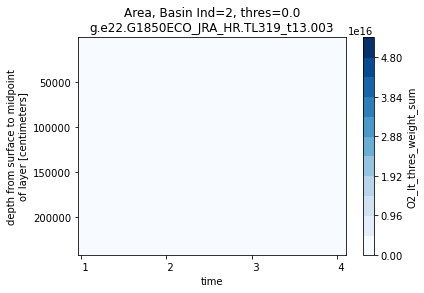

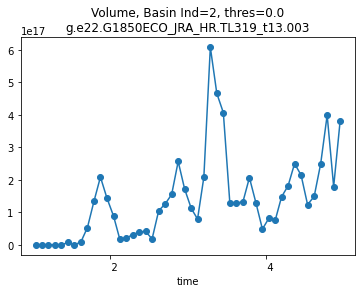

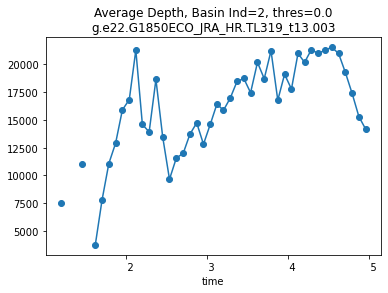

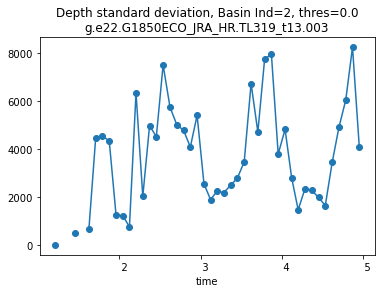

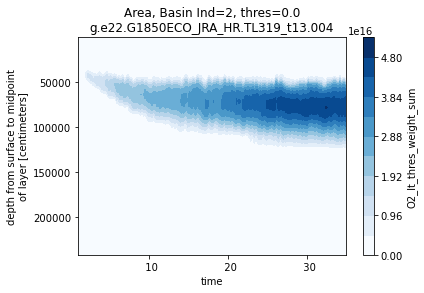

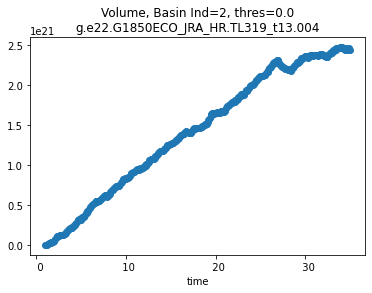

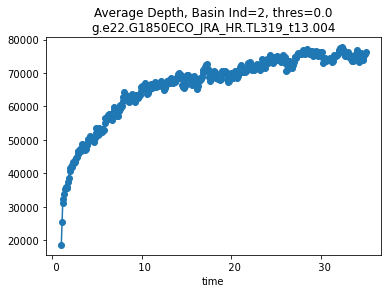

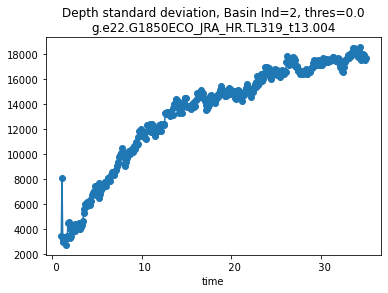

{'region_mask': 2, 'thres': 5.0, 'z_t': slice(0.0, 250000.0, None)}


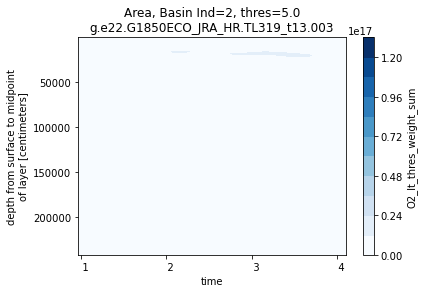

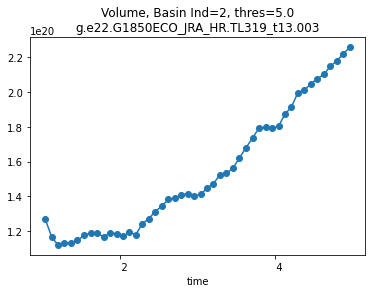

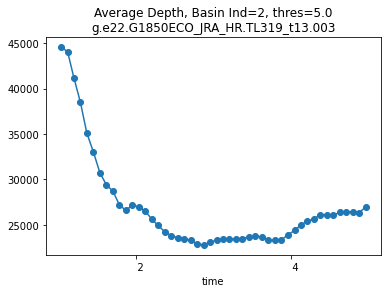

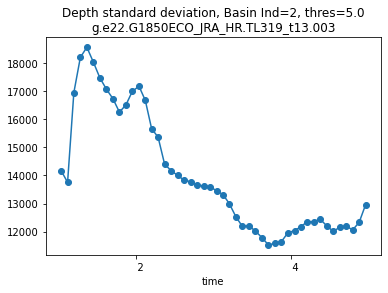

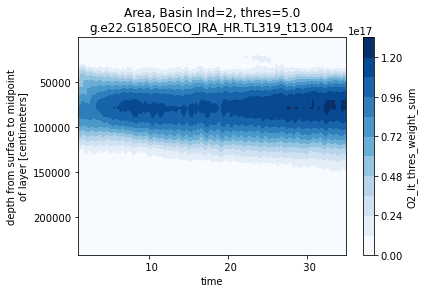

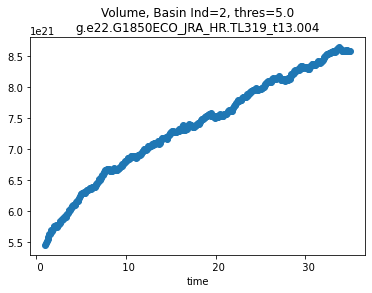

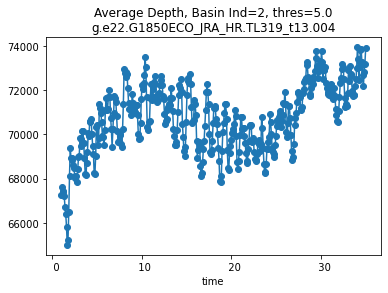

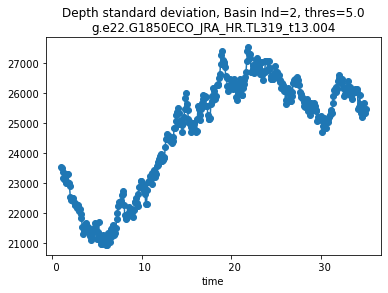

{'region_mask': 2, 'thres': 10.0, 'z_t': slice(0.0, 250000.0, None)}


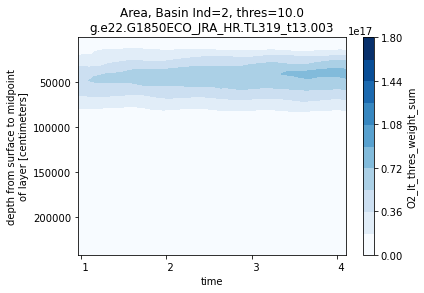

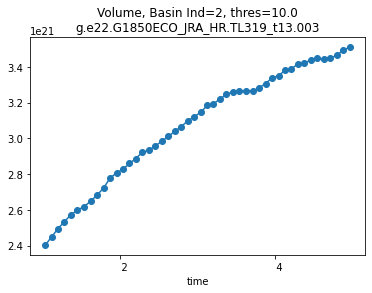

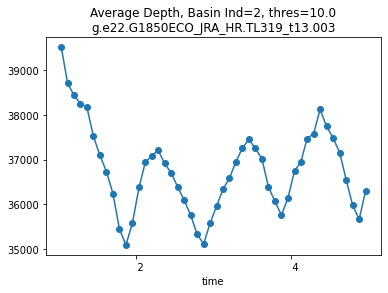

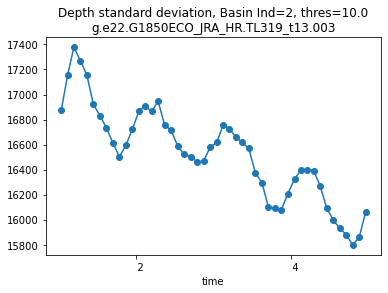

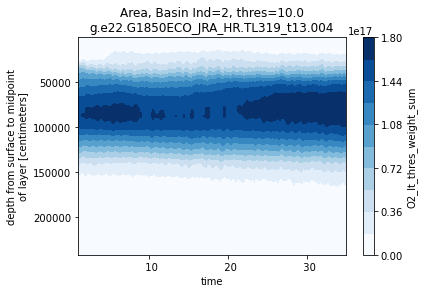

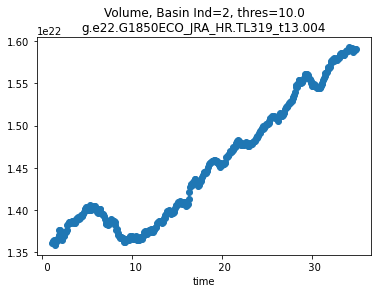

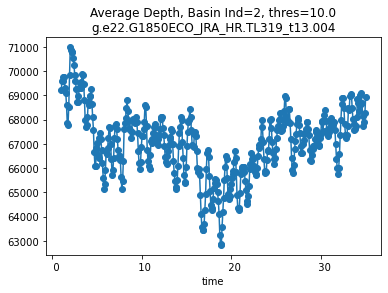

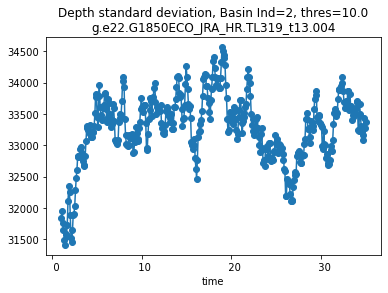

{'region_mask': 2, 'thres': 40.0, 'z_t': slice(0.0, 250000.0, None)}


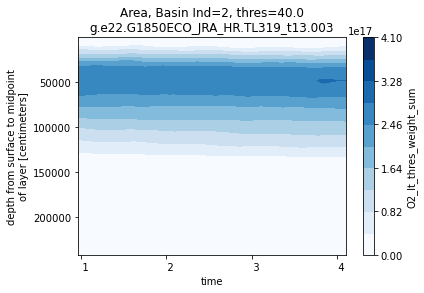

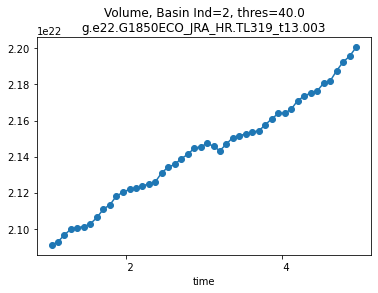

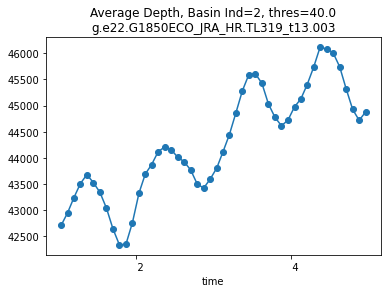

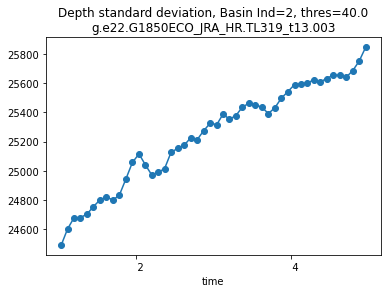

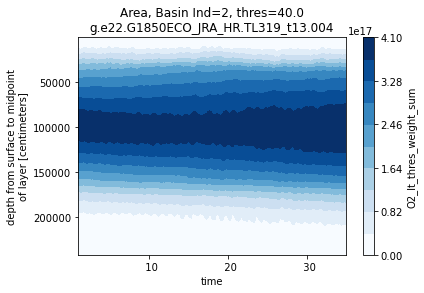

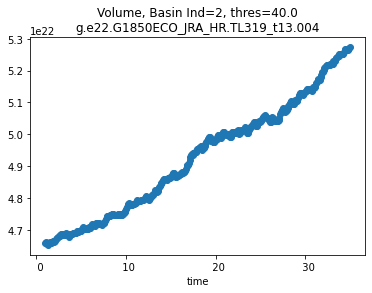

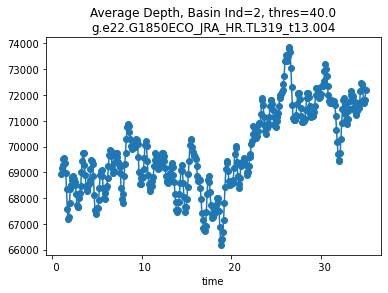

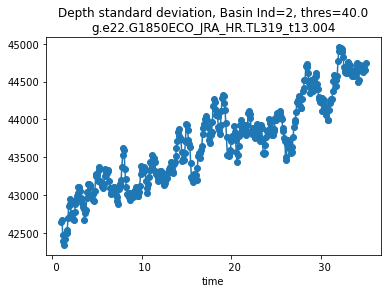

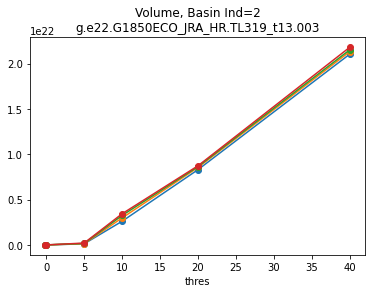

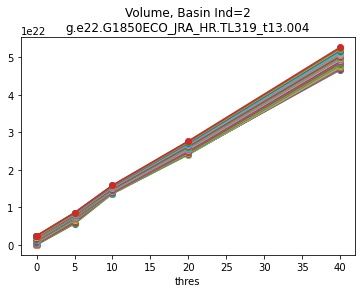

In [8]:
omz_plot(varname, region_mask_val=2)

{'region_mask': 3, 'thres': 0.0, 'z_t': slice(0.0, 250000.0, None)}


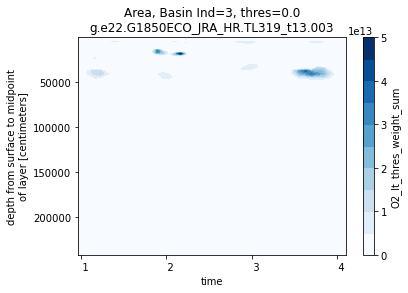

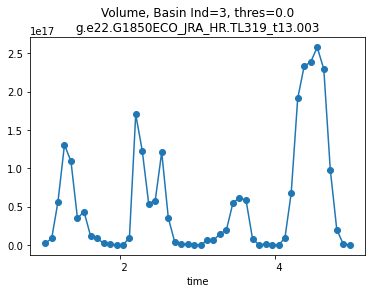

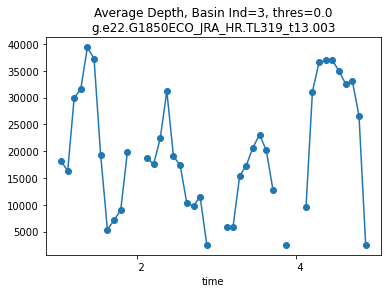

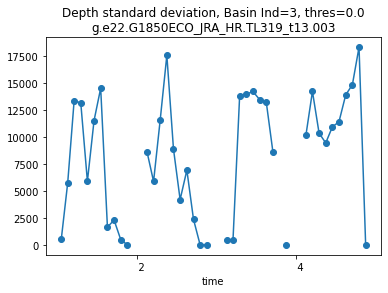

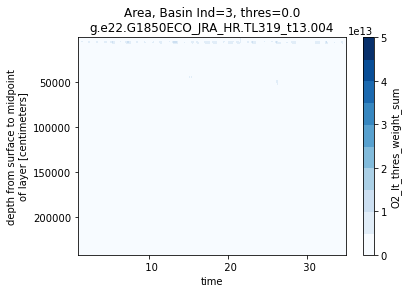

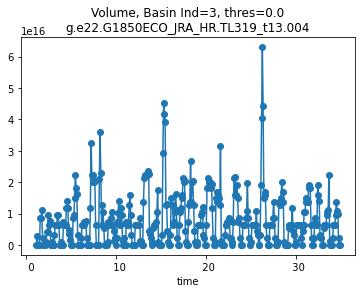

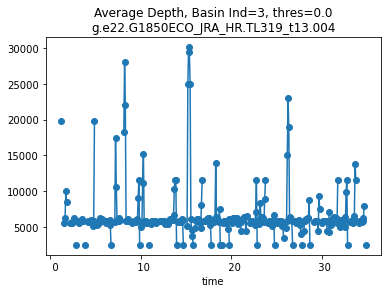

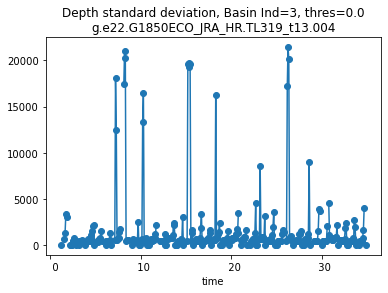

{'region_mask': 3, 'thres': 5.0, 'z_t': slice(0.0, 250000.0, None)}


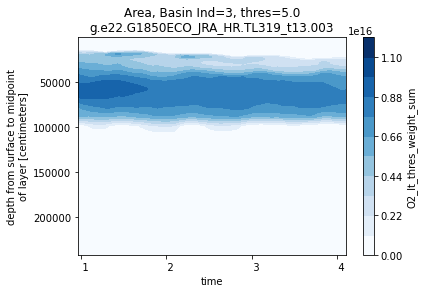

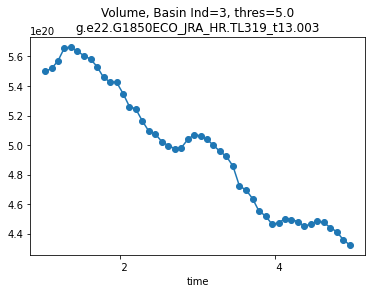

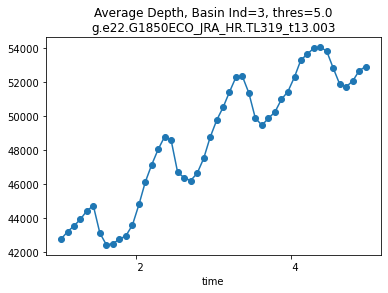

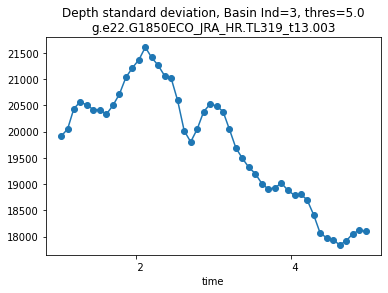

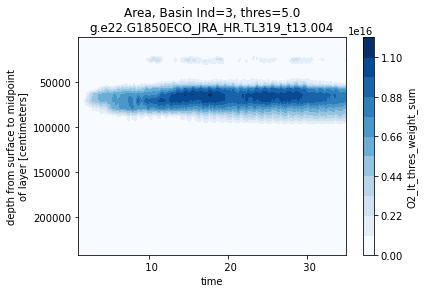

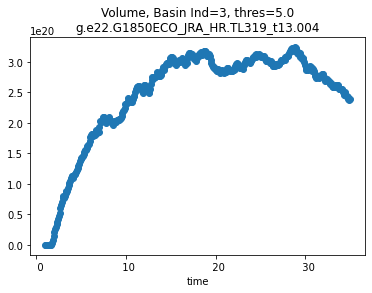

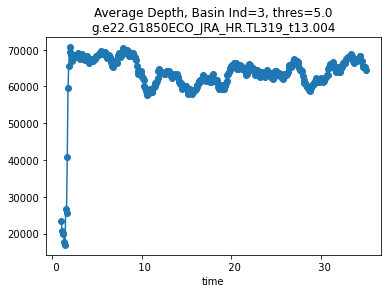

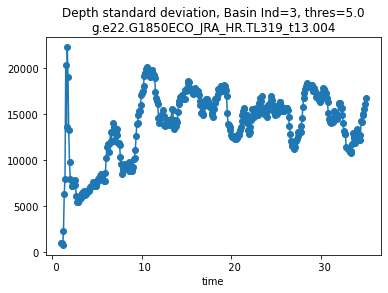

{'region_mask': 3, 'thres': 10.0, 'z_t': slice(0.0, 250000.0, None)}


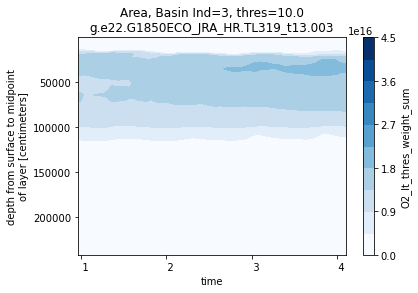

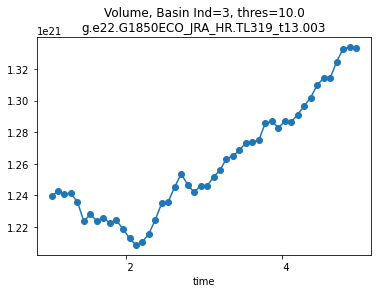

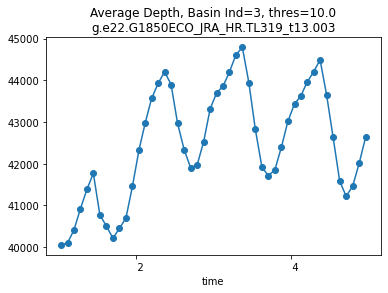

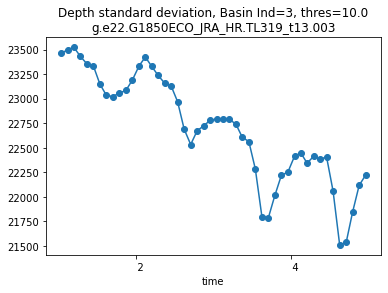

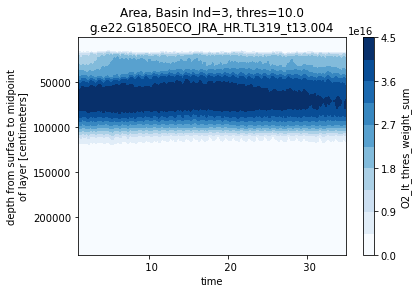

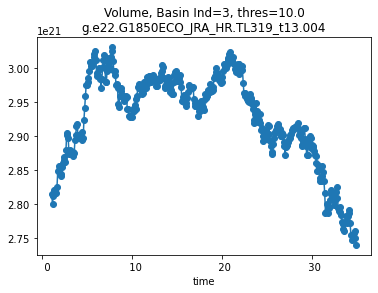

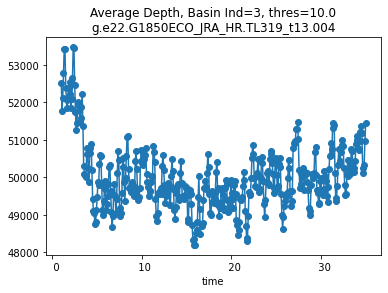

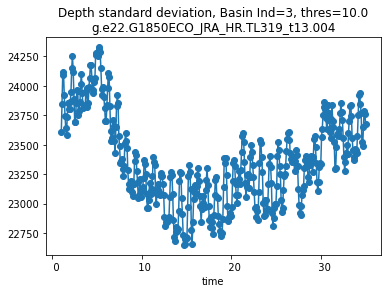

{'region_mask': 3, 'thres': 40.0, 'z_t': slice(0.0, 250000.0, None)}


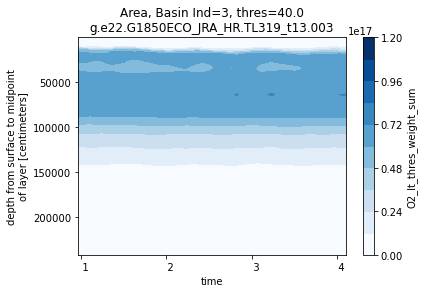

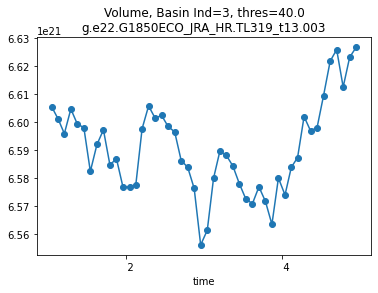

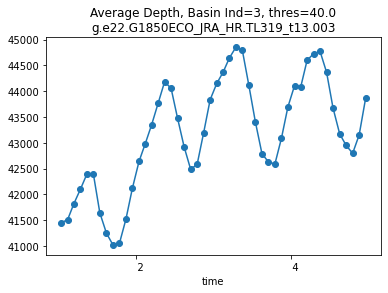

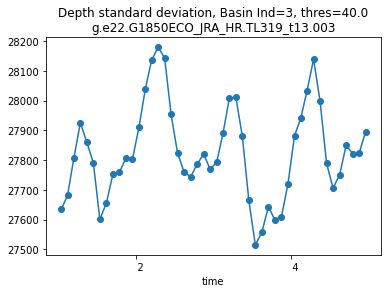

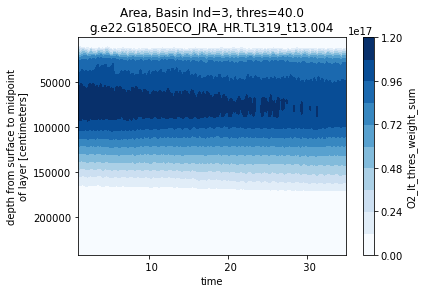

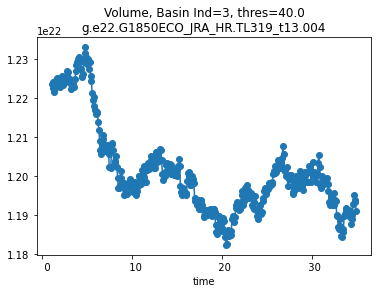

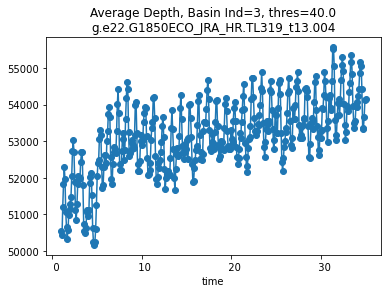

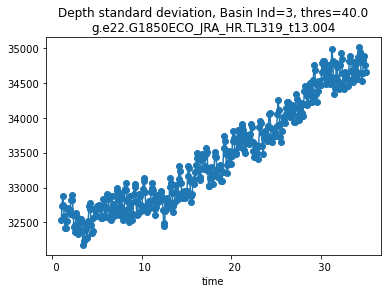

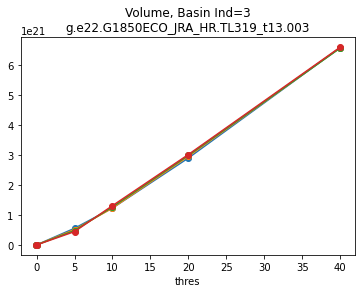

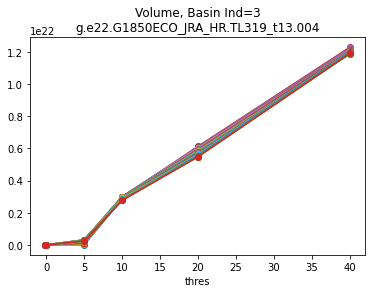

In [9]:
omz_plot(varname, region_mask_val=3)

{'region_mask': 6, 'thres': 0.0, 'z_t': slice(0.0, 250000.0, None)}


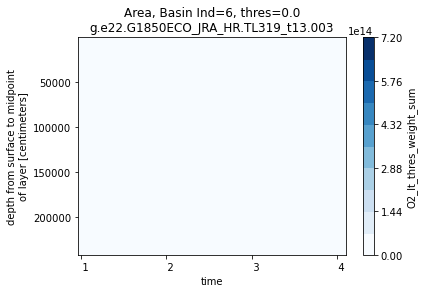

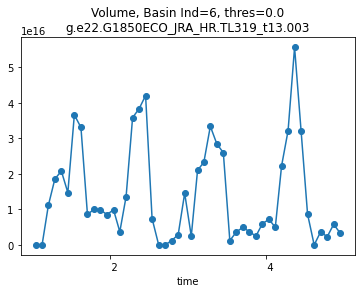

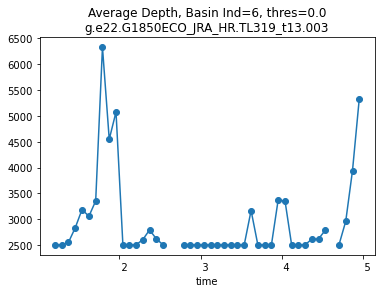

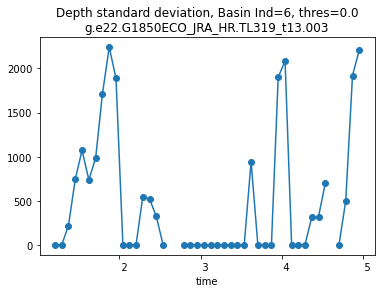

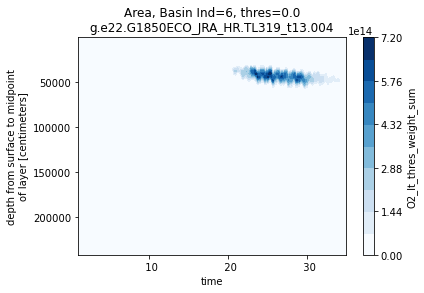

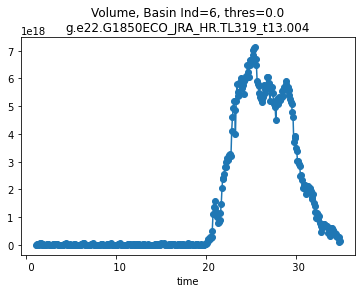

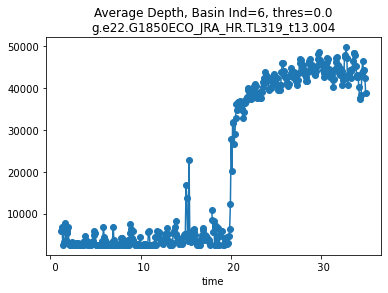

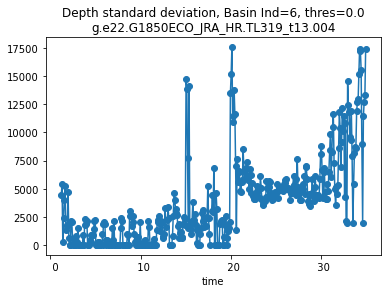

{'region_mask': 6, 'thres': 5.0, 'z_t': slice(0.0, 250000.0, None)}


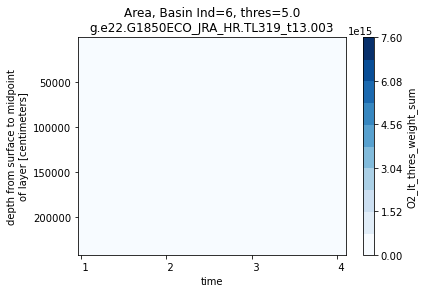

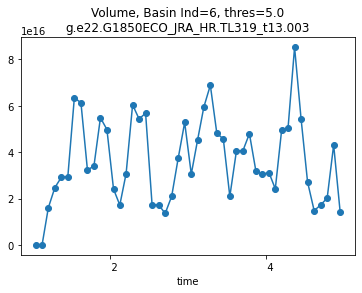

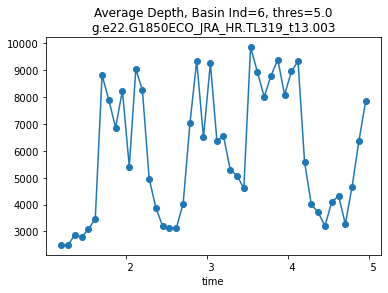

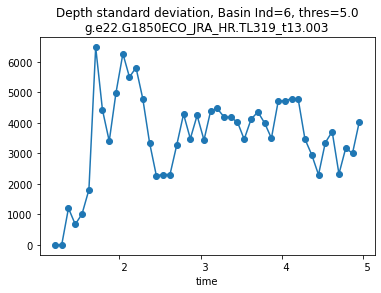

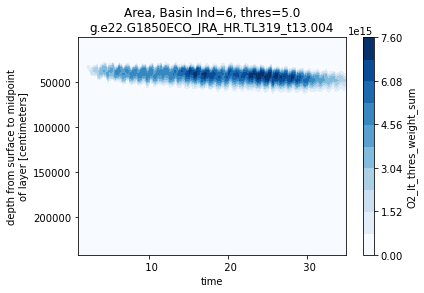

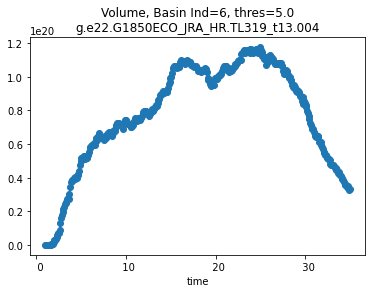

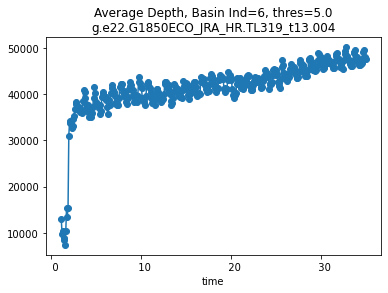

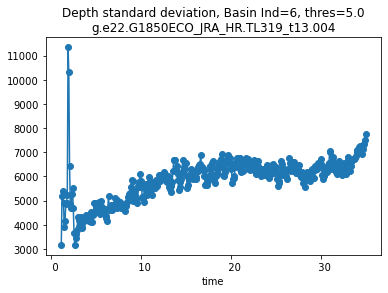

{'region_mask': 6, 'thres': 10.0, 'z_t': slice(0.0, 250000.0, None)}


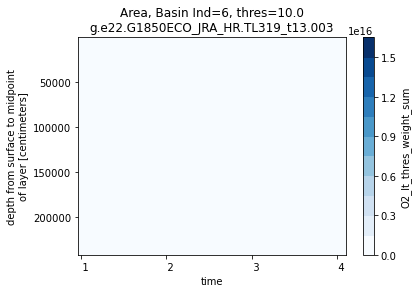

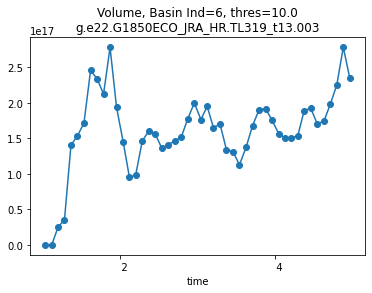

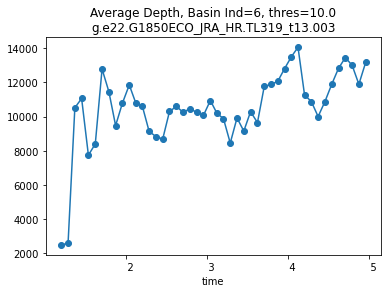

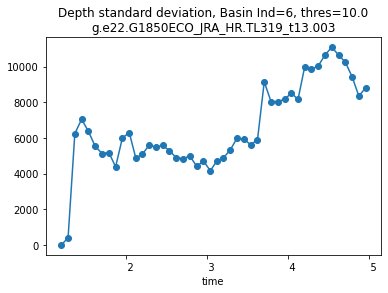

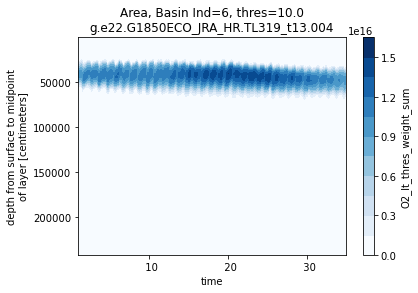

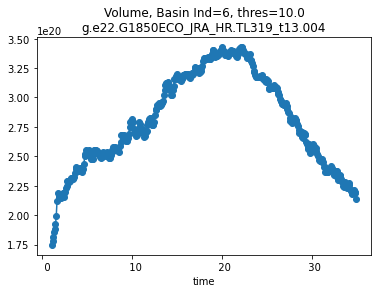

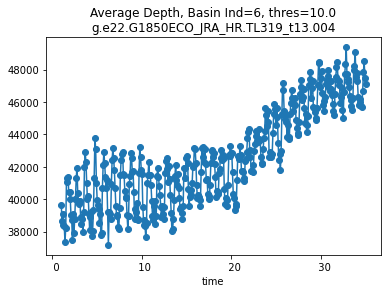

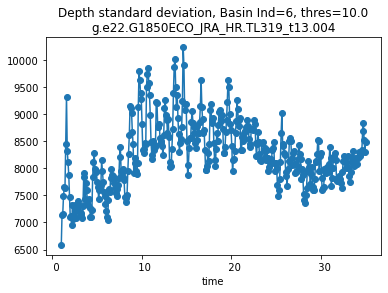

{'region_mask': 6, 'thres': 40.0, 'z_t': slice(0.0, 250000.0, None)}


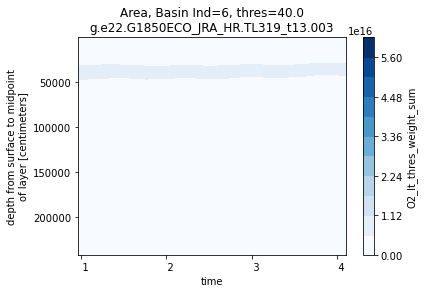

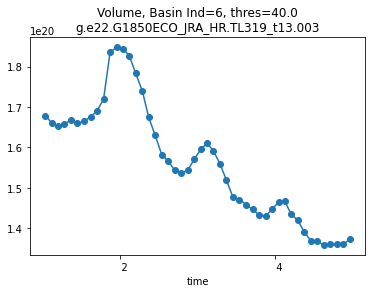

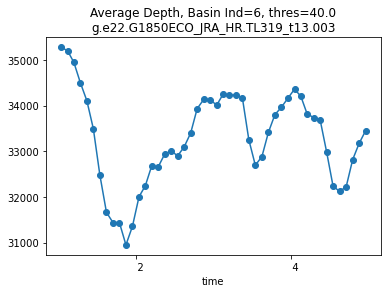

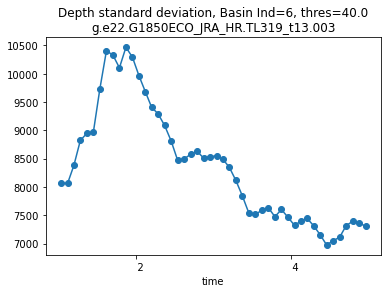

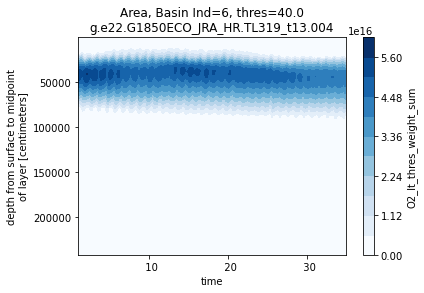

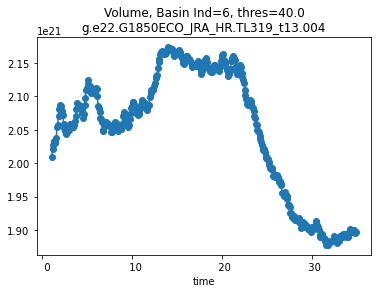

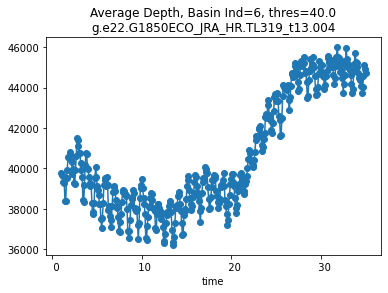

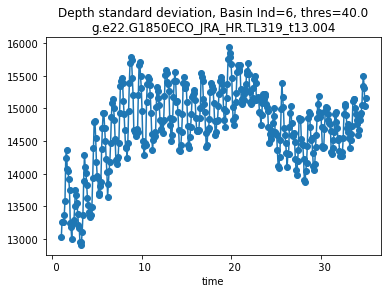

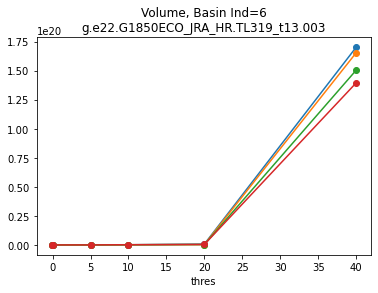

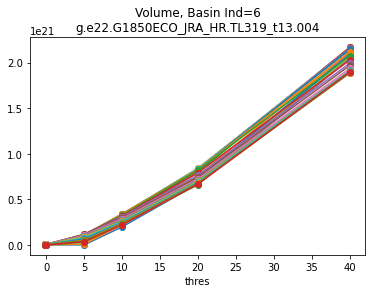

In [10]:
omz_plot(varname, region_mask_val=6)